<a href="https://colab.research.google.com/github/pboric/streamlit/blob/main/Podcasts_reviews_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Podcast Reviews Dataset Analysis Notebook


This notebook is an analysis of a Podcast Reviews Dataset. Here’s a brief summary:

**Import Libraries**: The notebook begins by importing necessary libraries such as pandas, numpy, sqlite3, matplotlib, seaborn, scipy, and tabulate.

**Explore the Database**: The SQLite database is explored to understand the schema of the tables. The database is then queried to join the podcasts, categories, and reviews tables into a single DataFrame.

**Data Cleaning**: The ‘category’ column is cleaned by applying a mapping to consolidate similar categories. Rows with missing values and duplicates are dropped.

**Exploratory Data Analysis (EDA)**: The cleaned data is then analyzed. This includes checking for missing values and duplicates, visualizing the distribution of ratings, exploring the number of podcasts per category, analyzing the average rating by category, creating a word cloud for common words used in reviews, and performing sentiment analysis on the review content.

**Statistical Inference**: Two statistical tests are performed. The first test checks if there is a significant difference between the average sentiment polarity for the Arts category and the overall average sentiment polarity. The second test checks if the mean sentiment polarity for each podcast category is significantly different from zero.

**Exporting Data for Looker**: The data is aggregated by ‘category’ to calculate the mean rating and sentiment. This aggregated data is then exported to a CSV file for further analysis in Looker.

## Import libraries

In [ ]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tabulate import tabulate

## Explore the database

In [ ]:
# Connect to your SQLite database
conn = sqlite3.connect(r"C:\Users\kresi\Downloads\archive\database.sqlite")

# Get a list of all tables in the database
tables_query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql_query(tables_query, conn)

# Print out each table name and its schema
for table in tables['name']:
    schema_query = f"PRAGMA table_info({table});"
    schema = pd.read_sql_query(schema_query, conn)
    print(f"Schema of table '{table}':")
    print(schema)

# Close the connection
conn.close()


Schema of table 'runs':
   cid           name     type  notnull dflt_value  pk
0    0         run_at     TEXT        1       None   0
1    1      max_rowid  INTEGER        1       None   0
2    2  reviews_added  INTEGER        1       None   0
Schema of table 'podcasts':
   cid        name     type  notnull dflt_value  pk
0    0  podcast_id     TEXT        0       None   1
1    1   itunes_id  INTEGER        1       None   0
2    2        slug     TEXT        1       None   0
3    3  itunes_url     TEXT        1       None   0
4    4       title     TEXT        1       None   0
Schema of table 'categories':
   cid        name  type  notnull dflt_value  pk
0    0  podcast_id  TEXT        1       None   0
1    1    category  TEXT        1       None   0
Schema of table 'reviews':
   cid        name     type  notnull dflt_value  pk
0    0  podcast_id     TEXT        1       None   0
1    1       title     TEXT        1       None   0
2    2     content     TEXT        1       None   0
3   

We see that there are 4 tables in the dataset. We only need 3 of them ('podcasts', 'categories' and 'reviews')

## Load the executed query in a dataframe

In [ ]:
conn = sqlite3.connect(r"C:\Users\kresi\Downloads\archive\database.sqlite")

# SQL query to join podcasts, categories, and reviews tables
query = """
SELECT
    c.category,
    p.title AS podcast_title,
    r.rating,
    r.content
FROM
    podcasts p
JOIN
    categories c ON p.podcast_id = c.podcast_id
JOIN
    reviews r ON p.podcast_id = r.podcast_id;
"""

df = pd.read_sql_query(query, conn)
conn.close()

print(tabulate(df.head(10), headers='keys', tablefmt='psql'))

+----+----------------------+----------------------------+----------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|    | category             | podcast_title              |   rating | content                                                                                                                                                                                                                                   |
|----+----------------------+----------------------------+----------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|  0 | arts                 | Backstage at Tilles Center |        5 | Thanks for p

Executed query joins the table on a primary key which is podcast_id column. After execution the output is loaded in a dataframe df.

In [ ]:
unique_ratings = df['rating'].unique()
print(unique_ratings)

[5 1 3 4 2]


Ratings values range form 1-5.

In [ ]:
unique_categories = df['category'].unique()
print(unique_categories)


['arts' 'arts-performing-arts' 'music' 'arts-design' 'education'
 'society-culture' 'arts-visual-arts' 'leisure' 'leisure-hobbies'
 'arts-books' 'technology' 'society-culture-personal-journals'
 'society-culture-relationships' 'fiction' 'fiction-science-fiction'
 'arts-food' 'education-language-learning' 'fiction-drama' 'true-crime'
 'health-fitness' 'health-fitness-nutrition' 'history' 'comedy'
 'arts-fashion-beauty' 'tv-film' 'society-culture-places-travel'
 'comedy-comedy-interviews' 'kids-family' 'health-fitness-mental-health'
 'religion-spirituality' 'business' 'news' 'news-business-news'
 'education-courses' 'society-culture-philosophy' 'leisure-video-games'
 'tv-film-film-reviews' 'leisure-games' 'spirituality'
 'tv-film-film-history' 'business-careers' 'business-entrepreneurship'
 'science' 'science-earth-sciences' 'comedy-improv' 'tv-film-tv-reviews'
 'health-fitness-sexuality' 'news-politics' 'leisure-home-garden'
 'leisure-animation-manga' 'fiction-comedy-fiction' 'christian

There are many different categories and subcategories of the podcasts.

## Data Cleaning

In [ ]:
# Define the category mapping

category_mapping = {
    "arts.*": "Arts",
    "education.*": "Education",
    "science.*": "Science",
    "tv-film.*": "TV & Film",
    "leisure.*": "Leisure",
    "fiction.*": "Fiction",
    "health-fitness.*": "Health & Fitness",
    "religion.*": "Religion & Spirituality",
    "business.*": "Business",
    "news.*": "News",
    "sports.*": "Sports",
    "kids-family.*": "Kids & Family",
    "society-culture.*": "Society & Culture",
    "comedy.*": "Comedy",
    "music.*": "Music",
    "history": "History",
    "government": "Government",
    "law": "Law",
    "technology": "Technology",
    "true-crime": "True Crime",
    "spirituality": "Religion & Spirituality",
    "christianity": "Religion & Spirituality",
    "hinduism": "Religion & Spirituality",
    "judaism": "Religion & Spirituality",
    "islam": "Religion & Spirituality",
    "buddhism": "Religion & Spirituality",
}


# Create a copy of the original dataframe to avoid modifying it directly
df_cleaned = df.copy()

# Apply the mapping to modify the 'category' column directly
df_cleaned['category'] = df_cleaned['category'].replace(category_mapping, regex=True)

# Drop rows with missing values
df_cleaned = df_cleaned.dropna()

# Drop duplicate rows
df_cleaned = df_cleaned.drop_duplicates()

print(tabulate(df_cleaned.head(10), headers='keys', tablefmt='psql'))


+----+-------------------+----------------------------+----------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|    | category          | podcast_title              |   rating | content                                                                                                                                                                                                                                   |
|----+-------------------+----------------------------+----------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|  0 | Arts              | Backstage at Tilles Center |        5 | Thanks for providing the

The copy of dataframe df is cleaned of missing values and duplicates and stored in a new dataframe df_cleaned.

In [ ]:
unique_categories_cl = df_cleaned['category'].unique()
print(unique_categories_cl)

['Arts' 'Music' 'Education' 'Society & Culture' 'Leisure' 'Technology'
 'Fiction' 'True Crime' 'Health & Fitness' 'History' 'Comedy' 'TV & Film'
 'Kids & Family' 'Religion & Spirituality' 'Business' 'News' 'Science'
 'Government' 'Sports']


We can see that the 'categories' column is properly mapped.

## EDA

<class 'pandas.core.frame.DataFrame'>
Index: 2947842 entries, 0 to 4529482
Data columns (total 4 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   category       object
 1   podcast_title  object
 2   rating         int64 
 3   content        object
dtypes: int64(1), object(3)
memory usage: 112.5+ MB


None
             rating
count  2.947842e+06
mean   4.626529e+00
std    1.046234e+00
min    1.000000e+00
25%    5.000000e+00
50%    5.000000e+00
75%    5.000000e+00
max    5.000000e+00
category         0
podcast_title    0
rating           0
content          0
dtype: int64
0


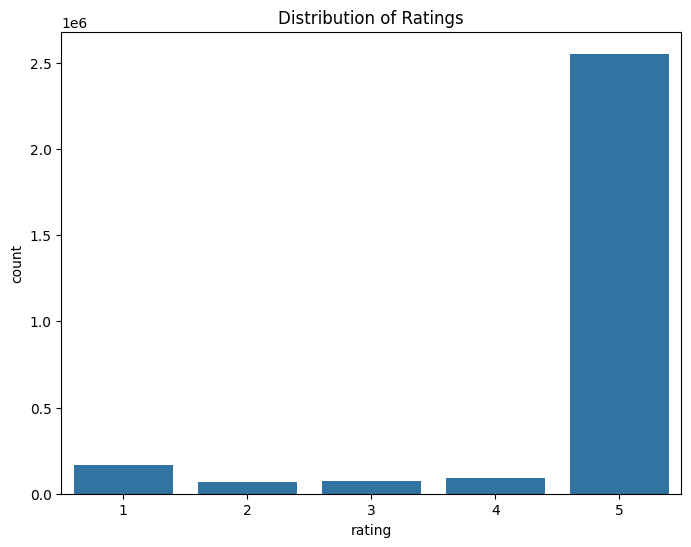

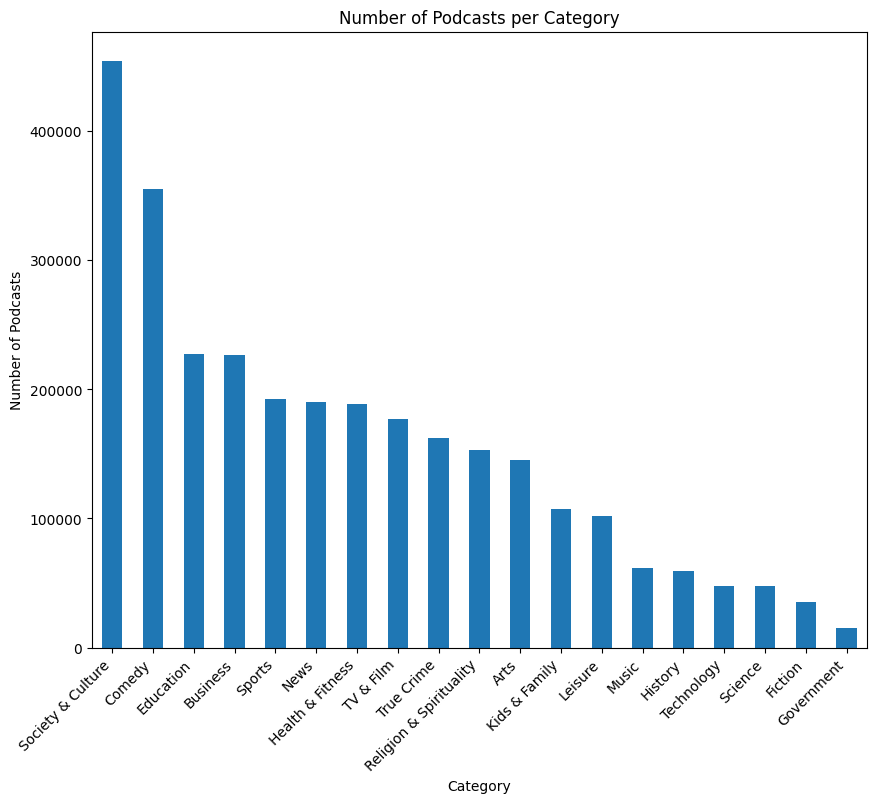

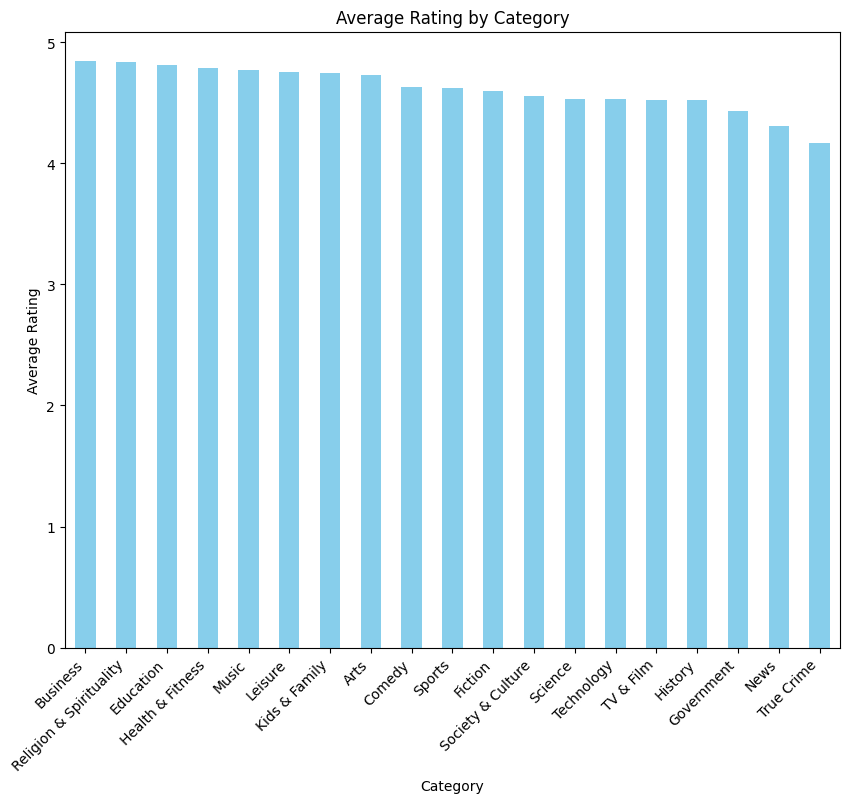

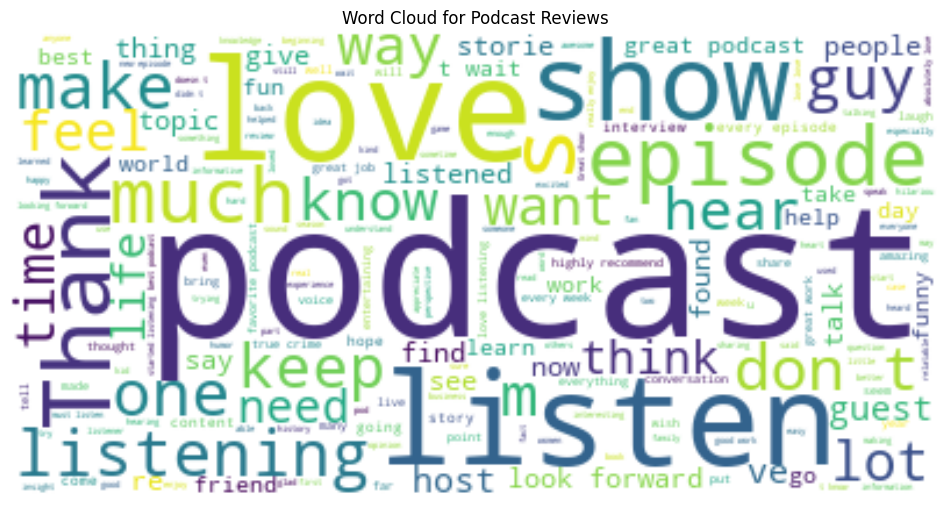

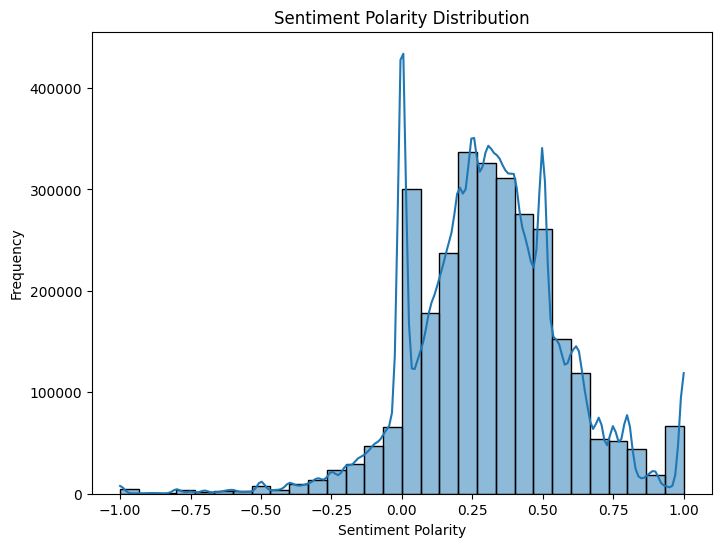

In [ ]:
# Let's start by getting a basic overview of the DataFrame
print(df_cleaned.info())
print(df_cleaned.describe())

# Check for missing values
print(df_cleaned.isnull().sum())

# Check for duplicates
print(df_cleaned.duplicated().sum())

# Visualize the distribution of ratings
plt.figure(figsize=(8, 6))
sns.countplot(x='rating', data=df_cleaned)
plt.title('Distribution of Ratings')
plt.show()

# Explore the number of podcasts per category
category_counts = df_cleaned['category'].value_counts()
plt.figure(figsize=(10, 8))
category_counts.plot(kind='bar')
plt.title('Number of Podcasts per Category')
plt.xlabel('Category')
plt.ylabel('Number of Podcasts')
plt.xticks(rotation=45, ha='right')
plt.show()

# Analyze the average rating by category
average_rating_by_category = df_cleaned.groupby('category')['rating'].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 8))
average_rating_by_category.plot(kind='bar', color='skyblue')
plt.title('Average Rating by Category')
plt.xlabel('Category')
plt.ylabel('Average Rating')
plt.xticks(rotation=45, ha='right')
plt.show()

# Word cloud for content column to visualize common words used in reviews
from wordcloud import WordCloud

# Join all reviews in a single string
text = ' '.join(review for review in df_cleaned['content'])
wordcloud = WordCloud(background_color='white').generate(text)

plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Podcast Reviews')
plt.show()

# Sentiment analysis on the content column
from textblob import TextBlob

# Function to calculate sentiment polarity
def calculate_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Apply the function to the content column
df_cleaned['sentiment'] = df_cleaned['content'].apply(calculate_sentiment)

# Visualize the sentiment distribution
plt.figure(figsize=(8, 6))
sns.histplot(df_cleaned['sentiment'], bins=30, kde=True)
plt.title('Sentiment Polarity Distribution')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()


We can see the results of basic statistcs of 'rating' column where the count of ratings is 2.95e+06, mean value is 4.63, std is 1.05, min is 1, 25% is 5, 50% is 5, 75% is 5, max is 5.

The distribution of ratings shows that the majority of podcasts are rated with rating 5.

The distribution of number of podcasts per category shows that the 'Society & Culture' category has the highest number of podcasts.

The distribution of average rating per category shows that the 'Business' category has the highest rating.

The word cloud of most used words in reviews shows that the most common words are: 'podcast', 'love', 'much', 'Thank', 'listen' etc.

The sentiment polarity histogram visualizes the frequency of sentiment polarity scores in a dataset, which range from negative (-1.0) to positive (1.0). Here are the key observations from the plot:

Neutral Sentiments: A significant peak around the 0.0 mark suggests that neutral sentiments are most common.

Sentiment Range: The sentiment polarity scores are spread across the full range from -1.0 to 1.0.

Frequency Peaks: There are multiple peaks, indicating several common sentiment scores within the dataset.

## Statistical Inference

### 1.

Null Hypothesis $(H_0)$:
- The null hypothesis states that there is no difference between the average sentiment polarity for the Arts category and the overall average sentiment polarity.
- Mathematically, it can be expressed as: $$[ H_0: \mu_{\text{Arts}} = \mu_{\text{Overall}} ]$$
- Where:
    - $\mu_{\text{Arts}}$ represents the population mean sentiment polarity for the Arts category.
    - $\mu_{\text{Overall}}$ represents the population mean sentiment polarity across all categories.
    
Alternative Hypothesis $(H_a)$:
- The alternative hypothesis states that there is a difference between the average sentiment polarity for the Arts category and the overall average sentiment polarity.
- Mathematically, it can be expressed as: $$[ H_a: \mu_{\text{Arts}} \neq \mu_{\text{Overall}} ]$$

In simpler terms, the null hypothesis assumes that any observed difference in sentiment polarity between Arts and the overall dataset is due to random chance. The alternative hypothesis suggests that there is a real difference in sentiment polarity specific to the Arts category. By rejecting the null hypothesis, we provide evidence in favor of the alternative hypothesis.

In [ ]:
# Sample data: sentiment polarity scores for the Arts category
arts_sentiments = df_cleaned[df_cleaned['category'] == 'Arts']['sentiment']

# Overall average sentiment polarity
overall_mean_sentiment = df_cleaned['sentiment'].mean()

# Two-sample t-test
t_stat, p_value = stats.ttest_1samp(arts_sentiments, overall_mean_sentiment)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpretation of the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in sentiment polarity.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in sentiment polarity.")


T-statistic: 31.64386196975918
P-value: 5.130324564839255e-219
Reject the null hypothesis: There is a significant difference in sentiment polarity.


This means there is a statistically significant difference in sentiment polarity, with a very high degree of certainty. The extremely low P-value suggests that the observed difference in sentiment polarity is not due to random chance.

In practical terms, this could mean that the sentiment expressed in one category of podcasts is significantly more positive or negative than the overall sentiment across all categories.

### 2.

Mean sentiment polarity for a given podcast category is equal to a hypothesized value, which is often zero (indicating a neutral sentiment).
For each podcast category, the null hypothesis can be formulated as follows:

$$[ H_0: \mu_{\text{category}} = 0 ]$$

Where:

$H_0$ is the null hypothesis.
$ \mu_{\text{category}} $ is the population mean sentiment polarity for the given podcast category.

The alternative hypothesis, on the other hand, is that the mean sentiment polarity is not equal to zero:

$$[ H_a: \mu_{\text{category}} \neq 0 ]$$

In [ ]:
# Define the significance level
alpha = 0.05

# List of categories to test
categories_to_test = df_cleaned['category'].unique()

# Dictionary to store test results
test_results = {}

# Perform t-tests and construct confidence intervals
for category in categories_to_test:
    # Filter the DataFrame for the specific category
    category_data = df_cleaned[df_cleaned['category'] == category]

    # Calculate the mean and standard deviation for sentiment
    mean_sentiment = category_data['sentiment'].mean()
    std_sentiment = category_data['sentiment'].std()

    # Sample size
    n = len(category_data)

    # Degrees of freedom
    df = n - 1

    # Calculate the standard error
    se = std_sentiment / np.sqrt(n)

    # Calculate the t-statistic for the sample mean (two-tailed test)
    t_stat = (mean_sentiment - 0) / se

    # Calculate the p-value
    p_value = stats.t.sf(np.abs(t_stat), df) * 2  # Multiply by 2 for two-tailed test

    # Construct the confidence interval
    ci = stats.t.interval(1 - alpha, df, loc=mean_sentiment, scale=se)

    # Store the results
    test_results[category] = {
        'mean_sentiment': mean_sentiment,
        'std_sentiment': std_sentiment,
        'n': n,
        't_stat': t_stat,
        'p_value': p_value,
        'confidence_interval': ci
    }

# Print the test results
for category, result in test_results.items():
    print(f"Category: {category}")
    print(f"Mean Sentiment: {result['mean_sentiment']}")
    print(f"Standard Deviation: {result['std_sentiment']}")
    print(f"Sample Size: {result['n']}")
    print(f"T-statistic: {result['t_stat']}")
    print(f"P-value: {result['p_value']}")
    print(f"Confidence Interval: {result['confidence_interval']}")
    print(f"{'Reject' if result['p_value'] < alpha else 'Fail to reject'} the null hypothesis.")
    print("-" * 50)

Category: Arts
Mean Sentiment: 0.33036548182299647
Standard Deviation: 0.25008225736756134
Sample Size: 145586
T-statistic: 504.04764493839826
P-value: 0.0
Confidence Interval: (0.3290808615378358, 0.33165010210815715)
Reject the null hypothesis.
--------------------------------------------------
Category: Music
Mean Sentiment: 0.3520496141928726
Standard Deviation: 0.2748176407038517
Sample Size: 61580
T-statistic: 317.89164090106345
P-value: 0.0
Confidence Interval: (0.34987900622952617, 0.35422022215621907)
Reject the null hypothesis.
--------------------------------------------------
Category: Education
Mean Sentiment: 0.3364156691565773
Standard Deviation: 0.2420187625998677
Sample Size: 226987
T-statistic: 662.2586995719373
P-value: 0.0
Confidence Interval: (0.33542003691834965, 0.3374113013948049)
Reject the null hypothesis.
--------------------------------------------------
Category: Society & Culture
Mean Sentiment: 0.30352583016912177
Standard Deviation: 0.26627451201992747
S

Since the p-values are extremely low (essentially zero), we have rejected the null hypothesis for all categories. This means we have found statistically significant evidence that the mean sentiment polarity is different from zero for each podcast category. The confidence intervals provided do not include zero, further supporting the rejection of the null hypothesis.

## Exporting data for Looker

In [ ]:
# Group the data by 'category' and calculate mean rating and sentiment
aggregated_data = df_cleaned.groupby('category').agg({
    'rating': ['mean', 'count', 'std'],
    'sentiment': ['mean', 'std']
}).reset_index()

# Flatten the MultiIndex columns
aggregated_data.columns = ['_'.join(col).strip() if col[1] else col[0] for col in aggregated_data.columns.values]

# Rename columns for clarity
aggregated_data.rename(columns={
    'category_': 'category',
    'rating_mean': 'average_rating',
    'rating_count': 'number_of_reviews',
    'rating_std': 'rating_std_dev',
    'sentiment_mean': 'average_sentiment',
    'sentiment_std': 'sentiment_std_dev'
}, inplace=True)

# Export the aggregated DataFrame to a CSV file
aggregated_data.to_csv('aggregated_data.csv', index=False)

print("Aggregated DataFrame exported to 'aggregated_data.csv' successfully!")

Aggregated DataFrame exported to 'aggregated_data.csv' successfully!


## Suggestions on analysis improvement

1. Data Exploration: Exploring the distribution of the number of reviews per podcast. This could provide insights into the popularity of different podcasts.

2. Feature Engineering: Create a feature that categorizes reviews as ‘positive’, ‘neutral’, or ‘negative’ based on their sentiment polarity. This could provide more granular insights into the reviews.

3. Visualizations: Using box plots or violin plots to visualize the distribution of ratings and sentiment across different categories. These plots can provide more detailed insights into the data distribution.

4. Statistical Analysis: Conducting chi-square tests for independence to explore relationships between categorical variables, such as ‘category’ and ‘rating’.

5. Text Analysis: Conducting more advanced text analysis, such as topic modeling or sentiment analysis, to gain deeper insights into the content of the reviews.

6. Modeling: Building a predictive model. This could be a regression model, a decision tree, or even a machine learning model, depending on the dataset and the question we’re trying to answer.